# Synopsis

We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

> Here we use the method of including probabilities of absent words.

#  Configuration

In [2]:
src_file = 'winereviews.csv'

# Set Hyperparameters
class Params():
    qntile_B = .1
    qntile_A = .9
    n_sets = 4
    smooth_alpha = .01
    binary_counts = True
params =  Params()

# Libraries

In [3]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import textman as tx

# Pragmas

In [4]:
%matplotlib inline

# Process

## Import wine reviews

In [5]:
docs = pd.read_csv('winereviews.csv', index_col='doc_id')

## Convert scores to labels

### Keep only reviews with high and low ratings

In [6]:
bound_A = int(docs.points.quantile(params.qntile_A))
bound_B = int(docs.points.quantile(params.qntile_B))
docs = docs[(docs.points <= bound_B) | (docs.points >= bound_A)]

### Assign labels for high and low

In [7]:
docs.loc[docs.points >= bound_A, 'doc_label'] = 'A'
docs.loc[docs.points <= bound_B, 'doc_label'] = 'B'

## Divide docs into train and test sets

### Assign random numbers to docs

In [8]:
docs['set'] = randint(0,params.n_sets, len(docs.index))

### Split docs by assigned number 

In [9]:
def split_docs(docs, n_sets=10, train_set=0, set_col='set'):
    docs.loc[docs[set_col] == train_set, 'training'] = 1
    docs['training'] = docs['training'].fillna(0).astype('int')
    return docs

In [10]:
docs = split_docs(docs, params.n_sets)

## Estimate class priors $p(c)$

In [110]:
Nc = docs.loc[docs['training'] == 1, 'doc_label'].value_counts()
N = len(docs.loc[docs['training'] == 1])
class_priors = Nc / N

In [111]:
np.round(class_priors, 2)

A    0.51
B    0.49
Name: doc_label, dtype: float64

Since these are literally $50/50$, we really don't need them.

### Convert priors to logs

In [112]:
class_priors_log = log(class_priors)

In [114]:
np.round(class_priors_log, 2)

A   -0.98
B   -1.02
Name: doc_label, dtype: float64

## Convert docs to tokens

In [115]:
tokens, vocab = tx.create_tokens_and_vocab(docs, src_col='doc_content')

### Collapse tokens 

We don't need sentences, so we collapse our table to document bags.

In [116]:
tokens = tokens.groupby(['doc_id','term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})

In [117]:
tokens.head()

n
doc_id term_id   
336    1107     1
       1374     1
       1732     1
       1750     1
       2256     1

## Transfer doc labels and splits to tokens

In [118]:
tokens = tokens.join(docs[['doc_label','training']], on='doc_id', how='left')

In [119]:
tokens.head()

n doc_label  training
doc_id term_id                       
336    1107     1         B         0
       1374     1         B         0
       1732     1         B         0
       1750     1         B         0
       2256     1         B         0

## Estimate likelihoods $p(w|c)$

In [120]:
class_likelihoods = tokens[tokens.training==1].groupby(['term_id','doc_label']).n.count().unstack().fillna(0)
class_likelihoods = class_likelihoods + params.smooth_alpha
class_likelihoods = class_likelihoods / class_likelihoods.sum()

In [121]:
class_likelihoods.head()

doc_label,A,B
term_id,,
381,3.256577e-05,1.819659e-07
386,1.081919e-07,3.657515e-05
388,2.174658e-05,1.819659e-07
392,1.083001e-04,1.819659e-07
393,4.338496e-05,1.819659e-07


## Add likelihood columns to test tokens table

In [144]:
testing_tokens = tokens[tokens.training==0]

In [145]:
testing_tokens = testing_tokens.join(class_likelihoods[['A','B']], on='term_id', how='right', sort=True)
testing_tokens.index.names = ['doc_id','term_id'] # Not sure why term_id gets lost

### Invert negatives

In [148]:
testing_tokens.loc[testing_tokens.n.isna(), ['A','B']] = 1 - testing_tokens[['A','B']]
testing_tokens[['A','B']] = log(testing_tokens[['A','B']])

In [149]:
testing_tokens.sample(5)

,,n,doc_label,training,A,B
doc_id,term_id,,,,,
61773,1955,1.0,B,0.0,-8.577125,-8.658403
71649,2958,1.0,A,0.0,-13.324521,-13.421161
121797,14587,1.0,B,0.0,-7.429932,-8.109275
28239,17420,1.0,A,0.0,-5.652904,-5.413924
127154,6213,1.0,B,0.0,-6.316126,-5.024864


In [158]:
# pd.concat([testing_tokens.A.unstack().T.sum(), testing_tokens.B.unstack().T.sum()], 1).idxmax(1)

## Create table to store results

In [84]:
results = pd.DataFrame(docs.loc[docs['training'] == 0].doc_label, index=docs.loc[docs['training'] == 0].index)

In [85]:
results.head()

,doc_label
doc_id,
336,B
337,B
339,B
340,B
342,B


## Estimate posteriors $p(c|w)$

In [86]:
results['A'] = exp(testing_tokens.groupby('doc_id').A.sum() + class_priors_log.A)
results['B'] = exp(testing_tokens.groupby('doc_id').B.sum() + class_priors_log.B)
results['prediction'] = results[['A','B']].idxmax(1)

In [87]:
results.head()

,doc_label,A,B,prediction
doc_id,,,,
336,B,1.422593e-96,9.589727e-80,B
337,B,3.512338e-66,1.341430e-61,B
339,B,2.485550e-30,7.954524e-26,B
340,B,1.125873e-39,1.610812e-38,B
342,B,4.197775e-64,1.663497e-53,B


## Show results

In [88]:
results['result'] = results.doc_label == results.prediction

In [89]:
results.head()

,doc_label,A,B,prediction,result
doc_id,,,,,
336,B,1.422593e-96,9.589727e-80,B,True
337,B,3.512338e-66,1.341430e-61,B,True
339,B,2.485550e-30,7.954524e-26,B,True
340,B,1.125873e-39,1.610812e-38,B,True
342,B,4.197775e-64,1.663497e-53,B,True


In [90]:
CM = results.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [91]:
CM

doc_label,A,B
prediction,,
A,8936,668
B,149,8387


```bash
AA | 11 | true positive  | TP | "hit," "power"                     
BB | 00 | true negative  | TN | "correct rejection"            
AB | 10 | false positive | FP | "false alarm," "Type I error"  
BA | 01 | false negative | FN | "miss," "Type II error"       
```

In [92]:
def get_results(CM):
    class Results():
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        PPV = TP / (TP + FP)
        ACC = (TP + TN) / (TP + TN + FP + FN)
        BA = (TNR + TPR) / 2
        F1 = (2 *  TP) / (2 * TP + FP + FN)
    return Results()

In [93]:
R = get_results(CM)

In [94]:
assert R.ALL == CM.sum().sum()

In [95]:
R.TP, R.FP, R.TN, R.FN, R.T, R.F, R.ALL

(8936, 668, 8387, 149, 17323, 817, 18140)

### Sensitivity

sensitivity, recall, hit rate, or true positive rate (TPR)

In IR, the probability that a (randomly selected) relevant document is retrieved in a search.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/73004d7856898ebe0bb1d1acd9e87b4be39b91a2)

In [96]:
R.TPR

0.983599339570721

### Specificity

specificity, selectivity or true negative rate (TNR)

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/67c35d27c765b463c514f44b0c654b30f4a1afb0)

In [97]:
R.TNR

0.926228602981778

### Precision

precision or positive predictive value (PPV)

In IR, the probability that a (randomly selected) retrieved document is relevant.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/d854b1544fc77735d575ce0d30e34d7f1eacf707)

In [98]:
R.PPV

0.9304456476468138

### Accuracy

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/be4377041f6e6226f0235bcc163db409f146090f)

In [99]:
R.ACC

0.9549614112458655

### Balanced Accuracy

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/4383d273906da14c55300ff47ac2e587d56da0cd)

In [100]:
R.BA

0.9549139712762496

### F1 Score

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2c1b789c877bcc32a7a317c723638b14857b7966)

In [101]:
R.F1

0.9562844453956874

### Summary of Performance

In [102]:
T1 = pd.DataFrame([(var, getattr(R, var)) for var in ['T','F','TP','FP','TN','FN','ALL']], columns=['metric','score'])\
    .set_index('metric').T

In [103]:
T2 = pd.DataFrame([(var, round(getattr(R, var),2)) for var in ['TPR','TNR','PPV','ACC','BA','F1']], columns=['metric','score'])\
    .set_index('metric').T

In [104]:
T1

metric,T,F,TP,FP,TN,FN,ALL
score,17323,817,8936,668,8387,149,18140


In [106]:
T2

metric,TPR,TNR,PPV,ACC,BA,F1
score,0.98,0.93,0.93,0.95,0.95,0.96


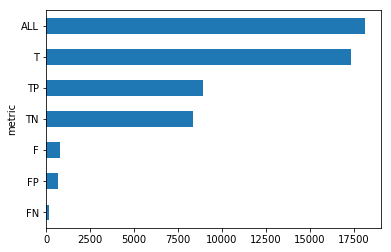

In [108]:
T1.T.sort_values('score').plot.barh(legend=False)

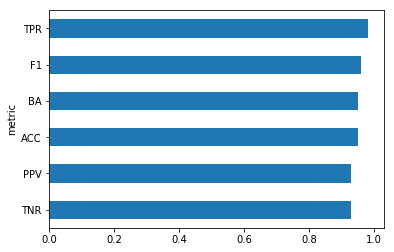

In [109]:
T2.T.sort_values('score').plot.barh(legend=False)